# Создание и предобработка нового датасета и формирование Content-based рекомендаций

Информация о фильмах была собрана с сайта Кинопоиск. В данных содержится 150 русских, 150 советских и 560 зарубежных фильмов

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Cчитываем несколько файлов, в которые были собранны данные

In [160]:
data_1 = pd.read_csv('datasets/kinopoisk/data_ru.csv')
data_2 = pd.read_csv('datasets/kinopoisk/data_ussr.csv')
data_3 = pd.read_csv('datasets/kinopoisk/data_foreign_1.csv')
data_4 = pd.read_csv('datasets/kinopoisk/data_foreign_2.csv')
data_5 = pd.read_csv('datasets/kinopoisk/data_foreign_3.csv')

files = [data_3, data_4, data_5, data_1, data_2]

data = pd.concat(files, ignore_index=True)
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Poster_Link,Series_Title,Released_Year,Runtime,Genre,Rating,Overview,Director,Star1,Star2
0,https://avatars.mds.yandex.net/get-kinopoisk-i...,Еретик,2024.0,1 ч 51 мин,"триллер, ужасы",6.7,Церковная миссия приводит двух молодых мормоно...,Скотт Бек,Хью Грант,Софи Тэтчер
1,https://avatars.mds.yandex.net/get-kinopoisk-i...,Субстанция,2024.0,2 ч 21 мин,"ужасы, драма",6.4,Слава голливудской звезды Элизабет Спаркл оста...,Корали Фаржа,Деми Мур,Маргарет Куолли
2,https://avatars.mds.yandex.net/get-kinopoisk-i...,Веном: Последний танец,2024.0,1 ч 50 мин,"фантастика, боевик, ужасы",6.5,"Приспособившись к совместному существованию, Э...",Келли Марсел,Том Харди,Джуно Темпл
3,https://avatars.mds.yandex.net/get-kinopoisk-i...,Ручная кладь,2024.0,1 ч 59 мин,"боевик, триллер, криминал",6.5,"Лос-Анджелес, рождественский день. Сотрудник с...",Жауме Кольет-Серра,Тэрон Эджертон,Джейсон Бейтман
4,https://avatars.mds.yandex.net/get-kinopoisk-i...,Анора,2024.0,2 ч 19 мин,"драма, мелодрама, комедия",7.4,Молодая стриптизерша из Бруклина внезапно выхо...,Шон Бэйкер,Майки Мэдисон,Марк Эйдельштейн


Смотрим основную информацию о датасете и об пропусказ в нем

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    928 non-null    object 
 1   Series_Title   928 non-null    object 
 2   Released_Year  928 non-null    float64
 3   Runtime        928 non-null    object 
 4   Genre          928 non-null    object 
 5   Rating         928 non-null    object 
 6   Overview       919 non-null    object 
 7   Director       928 non-null    object 
 8   Star1          922 non-null    object 
 9   Star2          922 non-null    object 
dtypes: float64(1), object(9)
memory usage: 76.1+ KB


In [162]:
data.shape

(972, 10)

Удаляем фильмы, для которых не было взято описание

In [163]:
data = data.dropna(subset=['Overview']).reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          919 non-null    int64  
 1   Poster_Link    919 non-null    object 
 2   Series_Title   919 non-null    object 
 3   Released_Year  919 non-null    float64
 4   Runtime        919 non-null    object 
 5   Genre          919 non-null    object 
 6   Rating         919 non-null    object 
 7   Overview       919 non-null    object 
 8   Director       919 non-null    object 
 9   Star1          913 non-null    object 
 10  Star2          913 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 79.1+ KB


Вместо пропусков в значениях актеров у фильмов, где их нет (например анимации, мультфильмы), вставляем значения заглушки

In [164]:
data['Star1'] = data['Star1'].fillna('Нет')
data['Star2'] = data['Star2'].fillna('Нет')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919 entries, 0 to 918
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          919 non-null    int64  
 1   Poster_Link    919 non-null    object 
 2   Series_Title   919 non-null    object 
 3   Released_Year  919 non-null    float64
 4   Runtime        919 non-null    object 
 5   Genre          919 non-null    object 
 6   Rating         919 non-null    object 
 7   Overview       919 non-null    object 
 8   Director       919 non-null    object 
 9   Star1          919 non-null    object 
 10  Star2          919 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 79.1+ KB


Проверяем столбец с рейтингами фильмов на соответствие значениям и заменяем неверные значения на медианные

In [165]:
data['Rating'].unique()

array(['6.7', '6.4', '6.5', '7.4', '5.5', '6.6', '7.0', '7.1', '8.0',
       '8.3', '7.3', '8.6', '8.7', '8.1', '6.9', '8.4', '7.9', '8.8', '–',
       '8.5', '7.2', '5.8', '8.2', '6.2', '5.6', '7.8', '7.6', '7.7',
       '5.9', '6.8', '5.3', '5.0', '6.3', '7.5', '9.1', '6.1', '5.4',
       '5.2', '3.8', '6.0', '8.9', '5.7', '4.9', '5.1', '4.8', '4.2',
       '4.6', 8.3, 7.1, 7.8, 8.2, 7.2, 7.7, 7.3, 6.8, 7.4, 6.6, 7.5, 8.0,
       6.3, 6.9, 6.5, 8.1, 7.9, 5.9, 4.5, 8.5, 7.0, 5.6, 7.6, 6.2, 6.4,
       5.8, 5.7, 6.7, 8.4, 6.0, 4.1, 5.4, 6.1, 8.8, 8.7, 8.6, 9.2],
      dtype=object)

In [166]:
data['Rating'].value_counts()['–']

12

In [167]:
rating_med = str(data['Rating'].loc[data['Rating'] != '–'].astype('float64').median())
data['Rating'].replace({'–': rating_med}, inplace=True)
data['Rating'].unique()

C:\Users\AirDrop\AppData\Local\Temp\ipykernel_6880\3705892660.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Rating'].replace({'–': rating_med}, inplace=True)


array(['6.7', '6.4', '6.5', '7.4', '5.5', '6.6', '7.0', '7.1', '8.0',
       '8.3', '7.3', '8.6', '8.7', '8.1', '6.9', '8.4', '7.9', '8.8',
       '7.7', '8.5', '7.2', '5.8', '8.2', '6.2', '5.6', '7.8', '7.6',
       '5.9', '6.8', '5.3', '5.0', '6.3', '7.5', '9.1', '6.1', '5.4',
       '5.2', '3.8', '6.0', '8.9', '5.7', '4.9', '5.1', '4.8', '4.2',
       '4.6', 8.3, 7.1, 7.8, 8.2, 7.2, 7.7, 7.3, 6.8, 7.4, 6.6, 7.5, 8.0,
       6.3, 6.9, 6.5, 8.1, 7.9, 5.9, 4.5, 8.5, 7.0, 5.6, 7.6, 6.2, 6.4,
       5.8, 5.7, 6.7, 8.4, 6.0, 4.1, 5.4, 6.1, 8.8, 8.7, 8.6, 9.2],
      dtype=object)

In [168]:
data=data.drop(columns=['index'])
data.head()

,Poster_Link,Series_Title,Released_Year,Runtime,Genre,Rating,Overview,Director,Star1,Star2
0,https://avatars.mds.yandex.net/get-kinopoisk-i...,Еретик,2024.0,1 ч 51 мин,"триллер, ужасы",6.7,Церковная миссия приводит двух молодых мормоно...,Скотт Бек,Хью Грант,Софи Тэтчер
1,https://avatars.mds.yandex.net/get-kinopoisk-i...,Субстанция,2024.0,2 ч 21 мин,"ужасы, драма",6.4,Слава голливудской звезды Элизабет Спаркл оста...,Корали Фаржа,Деми Мур,Маргарет Куолли
2,https://avatars.mds.yandex.net/get-kinopoisk-i...,Веном: Последний танец,2024.0,1 ч 50 мин,"фантастика, боевик, ужасы",6.5,"Приспособившись к совместному существованию, Э...",Келли Марсел,Том Харди,Джуно Темпл
3,https://avatars.mds.yandex.net/get-kinopoisk-i...,Ручная кладь,2024.0,1 ч 59 мин,"боевик, триллер, криминал",6.5,"Лос-Анджелес, рождественский день. Сотрудник с...",Жауме Кольет-Серра,Тэрон Эджертон,Джейсон Бейтман
4,https://avatars.mds.yandex.net/get-kinopoisk-i...,Анора,2024.0,2 ч 19 мин,"драма, мелодрама, комедия",7.4,Молодая стриптизерша из Бруклина внезапно выхо...,Шон Бэйкер,Майки Мэдисон,Марк Эйдельштейн


Просматриваем данные на наличие повторных строк и удаляем дубликаты

In [169]:
data.duplicated().sum()

59

In [170]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 918
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    860 non-null    object 
 1   Series_Title   860 non-null    object 
 2   Released_Year  860 non-null    float64
 3   Runtime        860 non-null    object 
 4   Genre          860 non-null    object 
 5   Rating         860 non-null    object 
 6   Overview       860 non-null    object 
 7   Director       860 non-null    object 
 8   Star1          860 non-null    object 
 9   Star2          860 non-null    object 
dtypes: float64(1), object(9)
memory usage: 73.9+ KB


Изменяем типы данных для столбцов года выпуска и рейтинга на числовые

In [171]:
data['Released_Year'] = data['Released_Year'].astype('int64')
data['Rating'] = data['Rating'].astype('float64')
data.dtypes

Poster_Link       object
Series_Title      object
Released_Year      int64
Runtime           object
Genre             object
Rating           float64
Overview          object
Director          object
Star1             object
Star2             object
dtype: object

Визуально смотрим на датасет и радуемся =)

In [172]:
data.head()

,Poster_Link,Series_Title,Released_Year,Runtime,Genre,Rating,Overview,Director,Star1,Star2
0,https://avatars.mds.yandex.net/get-kinopoisk-i...,Еретик,2024,1 ч 51 мин,"триллер, ужасы",6.7,Церковная миссия приводит двух молодых мормоно...,Скотт Бек,Хью Грант,Софи Тэтчер
1,https://avatars.mds.yandex.net/get-kinopoisk-i...,Субстанция,2024,2 ч 21 мин,"ужасы, драма",6.4,Слава голливудской звезды Элизабет Спаркл оста...,Корали Фаржа,Деми Мур,Маргарет Куолли
2,https://avatars.mds.yandex.net/get-kinopoisk-i...,Веном: Последний танец,2024,1 ч 50 мин,"фантастика, боевик, ужасы",6.5,"Приспособившись к совместному существованию, Э...",Келли Марсел,Том Харди,Джуно Темпл
3,https://avatars.mds.yandex.net/get-kinopoisk-i...,Ручная кладь,2024,1 ч 59 мин,"боевик, триллер, криминал",6.5,"Лос-Анджелес, рождественский день. Сотрудник с...",Жауме Кольет-Серра,Тэрон Эджертон,Джейсон Бейтман
4,https://avatars.mds.yandex.net/get-kinopoisk-i...,Анора,2024,2 ч 19 мин,"драма, мелодрама, комедия",7.4,Молодая стриптизерша из Бруклина внезапно выхо...,Шон Бэйкер,Майки Мэдисон,Марк Эйдельштейн


Количество фильмов по годам

Text(0.5, 1.0, 'Number of films by year')

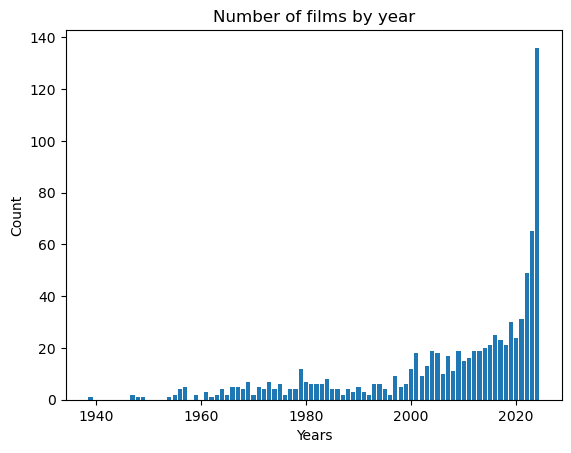

In [173]:
year_agg = data.groupby(['Released_Year'], as_index=False)['Series_Title'].count()
plt.bar(year_agg['Released_Year'], year_agg['Series_Title'])
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Number of films by year')

Распределение рейтингов фильмов

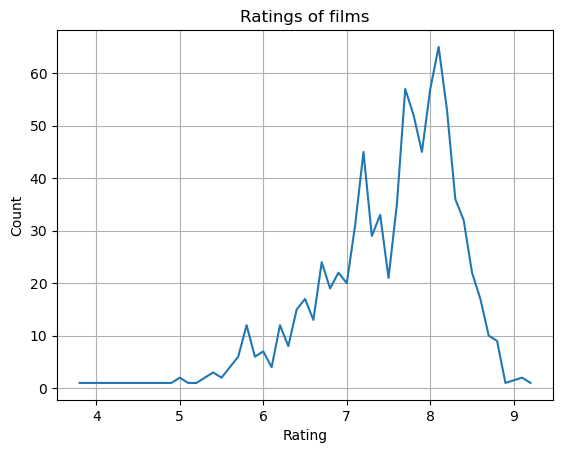

In [174]:
rating_agg = data.groupby(['Rating'], as_index=False)['Series_Title'].count()
plt.plot(rating_agg['Rating'], rating_agg['Series_Title'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings of films')
plt.grid()

Средние рейтинги фильмов за разные года

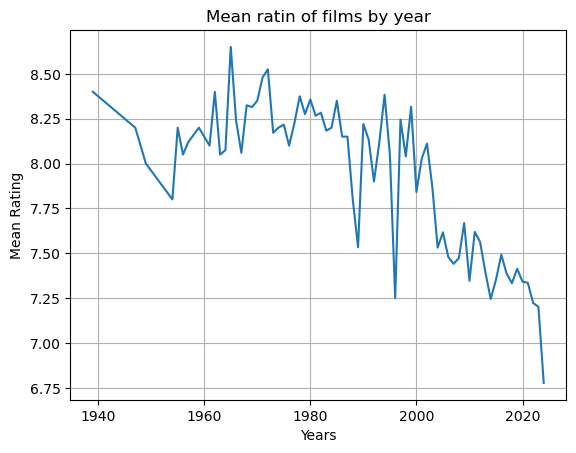

In [175]:
year_rating_agg = data.groupby(['Released_Year'], as_index=False)['Rating'].mean()
plt.plot(year_rating_agg['Released_Year'], year_rating_agg['Rating'])
plt.xlabel('Years')
plt.ylabel('Mean Rating')
plt.title('Mean ratin of films by year')
plt.grid()

Сохраняем датасет в файл

In [176]:
# data.to_csv('kinopoisk_top_850.csv', sep=',', encoding='utf-8')

Создаем рекомендационную систему и тестируем рекомендации

In [177]:
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

combined_features = data['Genre']+''+data['Director']+''+data['Star1']+''+data['Star2']+''+data['Overview']
#combined_features = data['Genre']+''+data['Overview']

vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)


In [178]:
cosine_sim = linear_kernel(feature_vectors, feature_vectors)
smd = data.reset_index()
titles = smd['Series_Title']
indices = pd.Series(smd.index, index=smd['Series_Title'])


def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['Series_Title', 'Rating']]
    qualified = movies.sort_values(by="Rating",ascending=False,axis=0).head(20)
    return qualified


In [179]:
get_recommendations('Чужой: Ромул')

,Series_Title,Rating
121,Побег из Шоушенка,9.1
211,Матрица,8.5
446,Прислуга,8.2
795,"Свой среди чужих, чужой среди своих",8.2
252,Пятый элемент,8.1
234,Гордость и предубеждение,8.1
123,Малышка на миллион,8.1
277,Чужой,8.1
173,Аватар,8.0
124,Что гложет Гилберта Грейпа,7.9
